In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, PrecisionRecallDisplay, precision_score, recall_score, roc_auc_score, RocCurveDisplay, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from datetime import timedelta
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV #GridSearch is for hyperparameter tuning
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

In [64]:
# read all tables
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

MERGE DATA

In [65]:
# step 1: marketing data at a customer level
marketing_agg = marketing[marketing['response']=='Yes'].groupby('customer_id')['campaign_id'].count().to_frame()

In [66]:
# step 2: aggregate transaction data at a customer level
transactions_agg = transactions.groupby('customer_id').aggregate({'transaction_id':'count','transaction_amount':'sum'})

In [67]:
# step 3: set customers and engagement index as customer_id
customers.set_index('customer_id', inplace=True)
engagement.set_index('customer_id', inplace=True)

In [68]:
# step 4: join all tables
joint_data = customers.join(engagement).join(transactions_agg).join(marketing_agg)
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN


## DATA CLEANING & FEATURE ENGINEERING

LTV Calculation

In [69]:
# Calculation of LTV
joint_data.groupby('customer_id')['transaction_amount'].sum()

customer_id
1         3509.48
2         6081.32
3         1454.87
4         7874.68
5        15524.55
           ...   
9996      5498.20
9997      5848.30
9998      3503.13
9999      6721.86
10000     5775.83
Name: transaction_amount, Length: 10000, dtype: float64

In [70]:
joint_data['LTV'] = joint_data.groupby('customer_id')['transaction_amount'].sum()
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,LTV
customer_id,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0,3509.48
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0,6081.32
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0,1454.87
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0,7874.68
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN,15524.55


In [71]:
# 10% of age entries are blank 
null_counts = joint_data['age'].isnull().sum()
null_counts

1009

In [72]:
# Create KNNImputer instance - this is to clean the age data since it will be used in modelling
imputer = KNNImputer(n_neighbors=2)

In [73]:
# Apply the imputer to the age column
joint_data[['age']] = imputer.fit_transform(joint_data[['age']])

In [74]:
joint_data['campaign_id'].value_counts()

campaign_id
1.0    4011
2.0    2563
3.0     923
4.0     168
Name: count, dtype: int64

In [75]:
# over 20% of customers were not sent any marketing campaigns
null_counts = joint_data['campaign_id'].isnull().sum()
null_counts

2335

In [77]:
imputer = KNNImputer(n_neighbors=5)
joint_data[['campaign_id']] = imputer.fit_transform(joint_data[['campaign_id']])

In [78]:
# Convert transaction_date to datetime
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

In [79]:
# customer age (How long they have been a member)
joint_data['Customer_Join_Time'] = pd.to_datetime(joint_data['last_purchase_date']) - pd.to_datetime(joint_data['join_date'])
joint_data['Customer_Join_Time']

customer_id
1       118 days
2       777 days
3       544 days
4       243 days
5       494 days
          ...   
9996    240 days
9997    200 days
9998    135 days
9999     66 days
10000    98 days
Name: Customer_Join_Time, Length: 10000, dtype: timedelta64[ns]

In [80]:
# Avg transaction amount
joint_data['Avg_Transaction_Amount'] = (joint_data['LTV'])/(joint_data['transaction_id'])
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,LTV,Customer_Join_Time,Avg_Transaction_Amount
customer_id,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.000000,Female,North Shannonbury,10,15,1,6,3509.48,1.000000,3509.48,118 days,584.913333
2,2021-09-08,2023-10-25,43.467467,Male,Hillville,285,49,51,9,6081.32,2.000000,6081.32,777 days,675.702222
3,2021-06-01,2022-11-27,43.467467,NaN,North Latoyatown,192,73,25,6,1454.87,1.000000,1454.87,544 days,242.478333
4,2022-01-01,2022-09-01,29.000000,Male,Grossstad,110,30,17,20,7874.68,1.000000,7874.68,243 days,393.734000
5,2022-01-24,2023-06-02,43.467467,Male,East Matthewfort,161,2,7,24,15524.55,1.640965,15524.55,494 days,646.856250


In [81]:
# Tier Avg Spend
joint_data['Avg_Spending_Tier'] = pd.qcut(joint_data['Avg_Transaction_Amount'], 3, labels=['low', 'medium', 'high'])

In [82]:
# PREP Avg Spend for CATEGORICAL COLUMN 
def Avg_Spend_Categorical(x):
    if x == 'low':
        return 1
    elif x == 'medium':
        return 2
    elif x == 'high':
        return 3

In [83]:
joint_data['Avg_Spend_Categorical'] = joint_data['Avg_Spending_Tier'].apply(Avg_Spend_Categorical)
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,LTV,Customer_Join_Time,Avg_Transaction_Amount,Avg_Spending_Tier,Avg_Spend_Categorical
customer_id,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.000000,Female,North Shannonbury,10,15,1,6,3509.48,1.000000,3509.48,118 days,584.913333,medium,2
2,2021-09-08,2023-10-25,43.467467,Male,Hillville,285,49,51,9,6081.32,2.000000,6081.32,777 days,675.702222,high,3
3,2021-06-01,2022-11-27,43.467467,NaN,North Latoyatown,192,73,25,6,1454.87,1.000000,1454.87,544 days,242.478333,low,1
4,2022-01-01,2022-09-01,29.000000,Male,Grossstad,110,30,17,20,7874.68,1.000000,7874.68,243 days,393.734000,low,1
5,2022-01-24,2023-06-02,43.467467,Male,East Matthewfort,161,2,7,24,15524.55,1.640965,15524.55,494 days,646.856250,medium,2


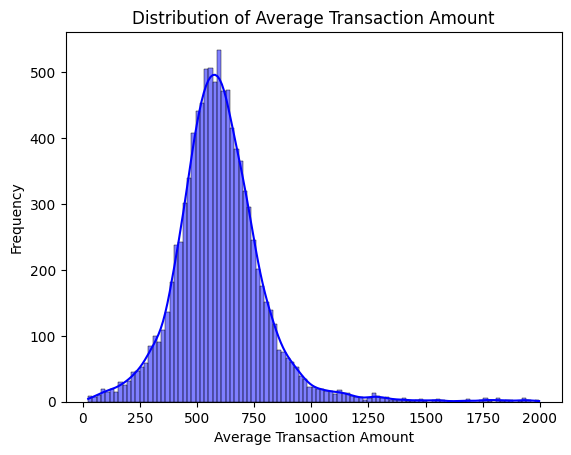

In [84]:
# Histogram to determine data distribution
sns.histplot(joint_data['Avg_Transaction_Amount'], kde=True, color='blue')  # KDE adds a density curve
plt.title('Distribution of Average Transaction Amount')
plt.xlabel('Average Transaction Amount')
plt.ylabel('Frequency')
plt.show()

In [85]:
# Most Recent Purchase (in days)
joint_data['most_recent_purchase_date'] = pd.to_datetime(joint_data['last_purchase_date'].max()) - pd.to_datetime(joint_data['last_purchase_date'])

In [86]:
# convert to an integer number of days for most recent purchase
joint_data['most_recent_purchase_in_days'] = joint_data['most_recent_purchase_date'].dt.days

In [87]:
# convert to an integer number of days for customer age
joint_data['Customer_Jointime_in_days']=joint_data['Customer_Join_Time'].dt.days

In [88]:
# Gender for CATEGORICAL COLUMN 
def Gender_Categorical(x):
    if x == 'Male':
        return 1
    elif x == 'Female':
        return 2
    else:
        return 0

In [89]:
joint_data['Gender_Categorical'] = joint_data['gender'].apply(Gender_Categorical)
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,LTV,Customer_Join_Time,Avg_Transaction_Amount,Avg_Spending_Tier,Avg_Spend_Categorical,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Jointime_in_days,Gender_Categorical
customer_id,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.000000,Female,North Shannonbury,10,15,1,6,3509.48,1.000000,3509.48,118 days,584.913333,medium,2,75 days,75,118,2
2,2021-09-08,2023-10-25,43.467467,Male,Hillville,285,49,51,9,6081.32,2.000000,6081.32,777 days,675.702222,high,3,219 days,219,777,1
3,2021-06-01,2022-11-27,43.467467,NaN,North Latoyatown,192,73,25,6,1454.87,1.000000,1454.87,544 days,242.478333,low,1,551 days,551,544,0
4,2022-01-01,2022-09-01,29.000000,Male,Grossstad,110,30,17,20,7874.68,1.000000,7874.68,243 days,393.734000,low,1,638 days,638,243,1
5,2022-01-24,2023-06-02,43.467467,Male,East Matthewfort,161,2,7,24,15524.55,1.640965,15524.55,494 days,646.856250,medium,2,364 days,364,494,1


In [90]:
# Scoring Frequency and Monetary: Higher values are better
joint_data['SiteVisit_Score'] = pd.qcut(joint_data['number_of_site_visits'], 4, labels=[1, 2, 3, 4])
joint_data['EmailOpen_Score'] = pd.qcut(joint_data['number_of_emails_opened'], 4, labels=[1, 2, 3, 4])
joint_data['Click_Score'] = pd.qcut(joint_data['number_of_clicks'], 4, labels=[1, 2, 3, 4])

# Combine scores to a single score
joint_data['Engagement_Score'] = joint_data['SiteVisit_Score'].astype(int) + joint_data['EmailOpen_Score'].astype(int) + joint_data['Click_Score'].astype(int)
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,Avg_Spending_Tier,Avg_Spend_Categorical,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Jointime_in_days,Gender_Categorical,SiteVisit_Score,EmailOpen_Score,Click_Score,Engagement_Score
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.000000,Female,North Shannonbury,10,15,1,6,3509.48,...,medium,2,75 days,75,118,2,1,2,1,4
2,2021-09-08,2023-10-25,43.467467,Male,Hillville,285,49,51,9,6081.32,...,high,3,219 days,219,777,1,4,3,4,11
3,2021-06-01,2022-11-27,43.467467,NaN,North Latoyatown,192,73,25,6,1454.87,...,low,1,551 days,551,544,0,4,4,3,11
4,2022-01-01,2022-09-01,29.000000,Male,Grossstad,110,30,17,20,7874.68,...,low,1,638 days,638,243,1,3,3,3,9
5,2022-01-24,2023-06-02,43.467467,Male,East Matthewfort,161,2,7,24,15524.55,...,medium,2,364 days,364,494,1,4,1,2,7


In [91]:
joint_data['Engagement_Score'].describe()

count    10000.00000
mean         7.44240
std          2.89733
min          3.00000
25%          5.00000
50%          8.00000
75%         10.00000
max         12.00000
Name: Engagement_Score, dtype: float64

In [92]:
# PREP Engagement for CATEGORICAL COLUMN 
def Engage_Categorical(x):
    if x <=5:
        return 1
    elif x <=8:
        return 2
    elif x >= 10:
        return 3
    else:
        return 0

In [93]:
joint_data['Engage_Categorical'] = joint_data['Engagement_Score'].apply(Engage_Categorical)
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,Avg_Spend_Categorical,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Jointime_in_days,Gender_Categorical,SiteVisit_Score,EmailOpen_Score,Click_Score,Engagement_Score,Engage_Categorical
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.000000,Female,North Shannonbury,10,15,1,6,3509.48,...,2,75 days,75,118,2,1,2,1,4,1
2,2021-09-08,2023-10-25,43.467467,Male,Hillville,285,49,51,9,6081.32,...,3,219 days,219,777,1,4,3,4,11,3
3,2021-06-01,2022-11-27,43.467467,NaN,North Latoyatown,192,73,25,6,1454.87,...,1,551 days,551,544,0,4,4,3,11,3
4,2022-01-01,2022-09-01,29.000000,Male,Grossstad,110,30,17,20,7874.68,...,1,638 days,638,243,1,3,3,3,9,0
5,2022-01-24,2023-06-02,43.467467,Male,East Matthewfort,161,2,7,24,15524.55,...,2,364 days,364,494,1,4,1,2,7,2


In [94]:
# Avg Transaction Time = how often do they make a transaction (in days)
joint_data['Avg_Transaction_Time'] = joint_data['Customer_Jointime_in_days']/joint_data['transaction_id']
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Jointime_in_days,Gender_Categorical,SiteVisit_Score,EmailOpen_Score,Click_Score,Engagement_Score,Engage_Categorical,Avg_Transaction_Time
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.000000,Female,North Shannonbury,10,15,1,6,3509.48,...,75 days,75,118,2,1,2,1,4,1,19.666667
2,2021-09-08,2023-10-25,43.467467,Male,Hillville,285,49,51,9,6081.32,...,219 days,219,777,1,4,3,4,11,3,86.333333
3,2021-06-01,2022-11-27,43.467467,NaN,North Latoyatown,192,73,25,6,1454.87,...,551 days,551,544,0,4,4,3,11,3,90.666667
4,2022-01-01,2022-09-01,29.000000,Male,Grossstad,110,30,17,20,7874.68,...,638 days,638,243,1,3,3,3,9,0,12.150000
5,2022-01-24,2023-06-02,43.467467,Male,East Matthewfort,161,2,7,24,15524.55,...,364 days,364,494,1,4,1,2,7,2,20.583333


In [95]:
joint_data['location'].value_counts()

location
Lake James           15
North Christopher    12
Port John            11
West David           11
New John             10
                     ..
Adamstown             1
Lake Deborahburgh     1
New Joanna            1
New Lynnburgh         1
Hollytown             1
Name: count, Length: 7695, dtype: int64

In [96]:
# Create the LabelEncoder instance
label_encoder = LabelEncoder()

In [97]:
# Fit and transform the data
joint_data['location_encoded'] = label_encoder.fit_transform(joint_data['location'])

In [98]:
# Convert the encoded integers to floats
joint_data['location_encoded'] = joint_data['location_encoded'].astype(float)

## RF (1 MONTH, 3 MONTHS, 6 MONTHS, 12 MONTHS)

RF PREP

In [99]:
# Convert the 'date' column to datetime type
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

In [100]:
# set reference date
last_date = transactions['transaction_date'].max()

In [101]:
def calculate_rf(data, end_date, days_label):
    rf = data.groupby('customer_id').agg(
        recency = ('transaction_date', lambda x: (end_date - x.max()).days),
        frequency = ('transaction_id', 'count'),
        monetary = ('transaction_amount', 'sum')
    ).rename(columns={
        'recency': f'Recency_{days_label}',
        'frequency': f'Frequency_{days_label}',
        'monetary': f'Monetary_{days_label}'
    })
    return rf

1 MONTH

In [34]:
# Define the time periods
days_30 = last_date - timedelta(days=30)
last_30_days = transactions[(transactions['transaction_date'] > days_30) & (transactions['transaction_date'] <= last_date)]

In [35]:
rf_30 = calculate_rf(last_30_days, last_date, '30')
rf_30
# Conclusion: not enough data to conduct any modeling for rf on last 30 days

,Recency_30,Frequency_30,Monetary_30
customer_id,,,
7,13,3,1018.16
48,19,1,439.69
59,24,8,4848.62
66,8,20,10795.72
90,1,19,11212.55
...,...,...,...
9869,28,1,408.71
9873,1,20,8405.83
9875,28,1,114.28


3 MONTHS

In [36]:
days_90 = last_date - timedelta(days=90)
last_90_days = transactions[(transactions['transaction_date'] > days_90) & (transactions['transaction_date'] <= last_date)]
rf_90 = calculate_rf(last_90_days, last_date, '90')
rf_90

,Recency_90,Frequency_90,Monetary_90
customer_id,,,
1,80,1,146.86
7,13,3,1018.16
21,42,1,148.29
37,56,4,2136.82
38,65,2,299.14
...,...,...,...
9956,74,1,318.59
9973,50,6,4729.27
9976,49,2,456.78


In [37]:
# rf Score Creation for 3 months
# Scoring Recency: Lower recency is better
rf_90['R_Score'] = pd.qcut(rf_90['Recency_90'], 4, labels=[4, 3, 2, 1])

# Scoring Frequency and Monetary: Higher values are better
rf_90['F_Score'] = pd.qcut(rf_90['Frequency_90'], 4, labels=[1, 2, 3, 4])
rf_90['M_Score'] = pd.qcut(rf_90['Monetary_90'], 4, labels=[1, 2, 3, 4])

# Combine scores to a single score
rf_90['rf_Score'] = rf_90['R_Score'].astype(int) + rf_90['F_Score'].astype(int)
rf_90.head()

,Recency_90,Frequency_90,Monetary_90,R_Score,F_Score,M_Score,rf_Score
customer_id,,,,,,,
1,80,1,146.86,1,1,1,2
7,13,3,1018.16,4,2,1,6
21,42,1,148.29,3,1,1,4
37,56,4,2136.82,2,2,2,4
38,65,2,299.14,2,1,1,3


In [38]:
joint_data.columns

Index(['join_date', 'last_purchase_date', 'age', 'gender', 'location',
       'number_of_site_visits', 'number_of_emails_opened', 'number_of_clicks',
       'transaction_id', 'transaction_amount', 'campaign_id', 'LTV',
       'Customer_Join_Time', 'Avg_Transaction_Amount', 'Avg_Spending_Tier',
       'Avg_Spend_Categorical', 'most_recent_purchase_date',
       'most_recent_purchase_in_days', 'Customer_Jointime_in_days',
       'Gender_Categorical', 'SiteVisit_Score', 'EmailOpen_Score',
       'Click_Score', 'Engagement_Score', 'Engage_Categorical',
       'Avg_Transaction_Time'],
      dtype='object')

In [39]:
rf_90['90_day_avg'] = (rf_90['Monetary_90'])/(rf_90['Frequency_90'])

In [40]:
rf_90 = pd.merge(rf_90, joint_data[['LTV','age', 'Customer_Join_Time', 'Avg_Spend_Categorical', 'Customer_Jointime_in_days',
                                      'Engage_Categorical', 'Gender_Categorical','Avg_Transaction_Time' ]], on='customer_id', how='left')
rf_90.head()

,Recency_90,Frequency_90,Monetary_90,R_Score,F_Score,M_Score,rf_Score,90_day_avg,LTV,age,Customer_Join_Time,Avg_Spend_Categorical,Customer_Jointime_in_days,Engage_Categorical,Gender_Categorical,Avg_Transaction_Time
customer_id,,,,,,,,,,,,,,,,
1,80,1,146.86,1,1,1,2,146.860000,3509.48,56.000000,118 days,2,118,1,2,19.666667
7,13,3,1018.16,4,2,1,6,339.386667,1339.82,43.467467,170 days,1,170,2,2,34.000000
21,42,1,148.29,3,1,1,4,148.290000,6547.69,20.000000,406 days,3,406,3,1,40.600000
37,56,4,2136.82,2,2,2,4,534.205000,7184.76,54.000000,310 days,2,310,2,2,25.833333
38,65,2,299.14,2,1,1,3,149.570000,7710.39,43.467467,397 days,2,397,3,2,30.538462


6 MONTHS

In [102]:
days_180 = last_date - timedelta(days=180)
last_180_days = transactions[(transactions['transaction_date'] > days_180) & (transactions['transaction_date'] <= last_date)]
rf_180 = calculate_rf(last_180_days, last_date, '180')
rf_180.head()

,Recency_180,Frequency_180,Monetary_180
customer_id,,,
1,80,6,3509.48
7,13,5,1339.82
12,150,4,1587.62
15,162,2,1304.38
17,121,4,1314.81


In [103]:
# rf Score Creation for 6 months
# Scoring Recency: Lower recency is better
rf_180['R_Score'] = pd.qcut(rf_180['Recency_180'], 4, labels=[4, 3, 2, 1])

# Scoring Frequency and Monetary: Higher values are better
rf_180['F_Score'] = pd.qcut(rf_180['Frequency_180'], 4, labels=[1, 2, 3, 4])
rf_180['M_Score'] = pd.qcut(rf_180['Monetary_180'], 4, labels=[1, 2, 3, 4])

# Combine scores to a single score
rf_180['rf_Score'] = rf_180['R_Score'].astype(int) + rf_180['F_Score'].astype(int)
rf_180.head()

,Recency_180,Frequency_180,Monetary_180,R_Score,F_Score,M_Score,rf_Score
customer_id,,,,,,,
1,80,6,3509.48,3,2,3,5
7,13,5,1339.82,4,2,2,6
12,150,4,1587.62,1,2,2,3
15,162,2,1304.38,1,1,2,2
17,121,4,1314.81,2,2,2,4


In [104]:
rf_180['180_day_avg'] = (rf_180['Monetary_180'])/(rf_180['Frequency_180'])

In [105]:
rf_180 = pd.merge(rf_180, joint_data[['age', 'LTV', 'Customer_Join_Time', 'Avg_Spend_Categorical', 'Customer_Jointime_in_days',
                                      'Engage_Categorical', 'Gender_Categorical','Avg_Transaction_Time', 'location_encoded', 'campaign_id']], on='customer_id', how='left')
rf_180.head()

,Recency_180,Frequency_180,Monetary_180,R_Score,F_Score,M_Score,rf_Score,180_day_avg,age,LTV,Customer_Join_Time,Avg_Spend_Categorical,Customer_Jointime_in_days,Engage_Categorical,Gender_Categorical,Avg_Transaction_Time,location_encoded,campaign_id
customer_id,,,,,,,,,,,,,,,,,,
1,80,6,3509.48,3,2,3,5,584.913333,56.000000,3509.48,118 days,2,118,1,2,19.666667,4747.0,1.0
7,13,5,1339.82,4,2,2,6,267.964000,43.467467,1339.82,170 days,1,170,2,2,34.000000,4944.0,1.0
12,150,4,1587.62,1,2,2,3,396.905000,23.000000,9244.97,1059 days,3,1059,3,1,88.250000,5965.0,1.0
15,162,2,1304.38,1,1,2,2,652.190000,58.000000,10997.99,644 days,2,644,3,2,37.882353,5677.0,1.0
17,121,4,1314.81,2,2,2,4,328.702500,40.000000,2964.38,66 days,2,66,1,2,13.200000,1781.0,2.0


1 YEAR

In [45]:
days_365 = last_date - timedelta(days=365)
last_365_days = transactions[(transactions['transaction_date'] > days_365) & (transactions['transaction_date'] <= last_date)]
rf_365 = calculate_rf(last_365_days, last_date, '365')
rf_365.head()

,Recency_365,Frequency_365,Monetary_365
customer_id,,,
1,80,6,3509.48
7,13,5,1339.82
8,305,7,4693.03
9,306,1,252.74
12,150,5,3221.32


In [46]:
# rf Score Creation for 1 year
# Scoring Recency: Lower recency is better
rf_365['R_Score'] = pd.qcut(rf_365['Recency_365'], 4, labels=[4, 3, 2, 1])

# Scoring Frequency and Monetary: Higher values are better
rf_365['F_Score'] = pd.qcut(rf_365['Frequency_365'], 4, labels=[1, 2, 3, 4])
rf_365['M_Score'] = pd.qcut(rf_365['Monetary_365'], 4, labels=[1, 2, 3, 4])

# Combine scores to a single score
rf_365['rf_Score'] = rf_365['R_Score'].astype(int) + rf_365['F_Score'].astype(int)
rf_365.head()

,Recency_365,Frequency_365,Monetary_365,R_Score,F_Score,M_Score,rf_Score
customer_id,,,,,,,
1,80,6,3509.48,3,2,2,5
7,13,5,1339.82,4,2,1,6
8,305,7,4693.03,1,2,3,3
9,306,1,252.74,1,1,1,2
12,150,5,3221.32,3,2,2,5


In [47]:
rf_365['1_yr_avg'] = (rf_365['Monetary_365'])/(rf_365['Frequency_365'])

In [48]:
rf_365 = pd.merge(rf_365, joint_data[['age', 'LTV', 'Customer_Join_Time', 'Avg_Spend_Categorical', 'Customer_Jointime_in_days',
                                      'Engage_Categorical', 'Gender_Categorical','Avg_Transaction_Time' ]], on='customer_id', how='left')
rf_365.head()

,Recency_365,Frequency_365,Monetary_365,R_Score,F_Score,M_Score,rf_Score,1_yr_avg,age,LTV,Customer_Join_Time,Avg_Spend_Categorical,Customer_Jointime_in_days,Engage_Categorical,Gender_Categorical,Avg_Transaction_Time
customer_id,,,,,,,,,,,,,,,,
1,80,6,3509.48,3,2,2,5,584.913333,56.000000,3509.48,118 days,2,118,1,2,19.666667
7,13,5,1339.82,4,2,1,6,267.964000,43.467467,1339.82,170 days,1,170,2,2,34.000000
8,305,7,4693.03,1,2,3,3,670.432857,68.000000,11710.62,181 days,3,181,2,1,12.066667
9,306,1,252.74,1,1,1,2,252.740000,68.000000,10382.96,568 days,1,568,2,2,25.818182
12,150,5,3221.32,3,2,2,5,644.264000,23.000000,9244.97,1059 days,3,1059,3,1,88.250000


## MODEL BUILDING AND EVALUATION

3 MONTHS

In [49]:
rf_90['LTV'].describe()

count     1597.000000
mean      8525.637132
std       4489.206141
min         96.480000
25%       5022.530000
50%       8436.910000
75%      11919.220000
max      22364.720000
Name: LTV, dtype: float64

In [50]:
# 75th percentile or better for the rf score is used for binary output because we are trying to predict the highest value customers
rf_90['binary_output'] = rf_90['LTV'].apply(lambda x: 1 if x>=11919.22 else 0)
rf_90['binary_output'].value_counts()

binary_output
0    1197
1     400
Name: count, dtype: int64

In [51]:
rf_90.columns

Index(['Recency_90', 'Frequency_90', 'Monetary_90', 'R_Score', 'F_Score',
       'M_Score', 'rf_Score', '90_day_avg', 'LTV', 'age', 'Customer_Join_Time',
       'Avg_Spend_Categorical', 'Customer_Jointime_in_days',
       'Engage_Categorical', 'Gender_Categorical', 'Avg_Transaction_Time',
       'binary_output'],
      dtype='object')

In [52]:
# This model will predict whether there will be a large amount of high value customers 
X_90 = rf_90[['rf_Score','age','Customer_Jointime_in_days', 'Engage_Categorical', 'Gender_Categorical', 'Avg_Transaction_Time']]
y_90 = rf_90['binary_output']

In [53]:
# reserve 30% for testing
X_train_90, X_test_90, y_train_90, y_test_90 = train_test_split(X_90,y_90, test_size=0.3, random_state=42)

In [54]:
# build our pipeline that includes these transformations
numeric_columns_90 = ['rf_Score','age','Customer_Jointime_in_days', 'Avg_Transaction_Time']
categorical_columns_90 = ['Engage_Categorical', 'Gender_Categorical']

In [55]:
# create a pre-processing pipeline which includes the steps of Scaling numeric variables and encoding categoricals
preprocessor_90 = ColumnTransformer(
    transformers=[
        ('num',MinMaxScaler(), numeric_columns_90),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_columns_90)
    ]
)

In [56]:
# test 3 models with cross validation to see which ones work best for this data
knn_90 = KNeighborsClassifier()
logreg_90 = LogisticRegression()
nb_90 = GaussianNB()

In [57]:
# cross validation to determine in general which model works best for the given problem
knn_scores_90 = cross_val_score(knn_90, X_train_90, y_train_90, scoring='f1', cv=5)
logreg_scores_90 = cross_val_score(logreg_90, X_train_90, y_train_90, scoring='f1', cv=5)
nb_scores_90 = cross_val_score(nb_90, X_train_90, y_train_90, scoring='f1', cv=5)
print(np.mean(knn_scores_90))
print(np.mean(logreg_scores_90))
print(np.mean(nb_scores_90))

# KNN ruled out because it has lowest score Logreg will be put through the pipeline

0.27709690903453865
0.44641541774852833
0.18102811673698216


In [58]:
# build our pipeline
pipeline_90 = Pipeline(steps=[
    ('preprocessor', preprocessor_90),
    ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs'))])

In [59]:
# use GRID SEARCH to find the best combination of hyperparameters for our problem
param_grid_90 = {
  'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Algorithms to use in the optimization problem
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Norm used in the penalization
    'classifier__max_iter': [100, 200, 300]  # Maximum number of iterations taken for the solvers to converge
}

In [60]:
grid_search_90 = GridSearchCV(pipeline_90, param_grid_90, cv=5, verbose=1, scoring='f1')
grid_search_90.fit(X_train_90,y_train_90)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['rf_Score',
                                                                          'age',
                                                                          'Customer_Jointime_in_days',
                                                                          'Avg_Transaction_Time']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Engage_Categorical',
                                                                          'Gender_Categorical'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__max_iter': [100, 200, 300],
                         'classifier__penalty': ['l1', 'l2', 'elasticnet',
                                                 'none'],
                         'classifier__solver': ['newton-cg', 'lbfgs',
                                                'liblinear', 'sag', 'saga']},
             scoring='f1', verbose=1)

In [61]:
final_classifier_90 = LogisticRegression(
    C=grid_search_90.best_params_['classifier__C'],
    solver=grid_search_90.best_params_['classifier__solver'],
    penalty=grid_search_90.best_params_['classifier__penalty'],
    max_iter=grid_search_90.best_params_['classifier__max_iter']
)

In [62]:
final_pipeline_90 = Pipeline(steps=
                          [
                              ('preprocessor',preprocessor_90),
                              ('classifier',final_classifier_90)
                          ])

In [63]:
final_pipeline_90.fit(X_train_90,y_train_90)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['rf_Score', 'age',
                                                   'Customer_Jointime_in_days',
                                                   'Avg_Transaction_Time']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Engage_Categorical',
                                                   'Gender_Categorical'])])),
                ('classifier',
                 LogisticRegression(C=100, penalty='l1', solver='liblinear'))])

In [64]:
pred_90 = final_pipeline_90.predict(X_test_90)
probs_90 = final_pipeline_90.predict_proba(X_test_90)

In [65]:
report_90 = classification_report(y_test_90, pred_90)
print(report_90)

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       353
           1       0.75      0.40      0.52       127

    accuracy                           0.81       480
   macro avg       0.78      0.68      0.70       480
weighted avg       0.80      0.81      0.78       480



RandomForestRegressor - 3 MONTH RFM

In [66]:
# Create a RandomForestRegressor object
model_90RFR = RandomForestRegressor(n_estimators=100, random_state=42)
# Splitting the data into training and testing sets
X_train_90RFR, X_test_90RFR, y_train_90RFR, y_test_90RFR = train_test_split(X_90, y_90, test_size=0.3, random_state=42)

In [67]:
# Fit the model to the training data
model_90RFR.fit(X_train_90RFR, y_train_90RFR)

RandomForestRegressor(random_state=42)

In [68]:
y_pred_90RFR= model_90RFR.predict(X_test_90RFR)
y_pred_90RFR

array([0.07      , 0.02      , 0.01      , 0.        , 0.45      ,
       0.        , 0.55      , 0.1       , 0.        , 0.63      ,
       0.03      , 0.        , 0.        , 0.        , 0.6       ,
       0.2175    , 0.02      , 0.02      , 0.09      , 0.11      ,
       0.        , 0.        , 0.        , 0.77      , 0.06      ,
       0.        , 0.04      , 0.75      , 0.01      , 0.07      ,
       0.        , 0.        , 0.        , 0.67      , 0.        ,
       0.        , 0.41      , 0.        , 0.235     , 0.446     ,
       0.82      , 0.24      , 0.        , 0.005     , 0.78      ,
       0.04      , 0.01      , 0.84      , 0.02      , 0.26      ,
       0.        , 0.13      , 0.02      , 0.02      , 0.04      ,
       0.31      , 0.6       , 0.01      , 0.13      , 0.01      ,
       0.74      , 0.        , 0.01      , 0.36      , 0.17      ,
       0.59      , 0.        , 0.02      , 0.        , 0.25416667,
       0.52      , 0.2       , 0.01      , 0.61      , 0.02   

In [69]:
# Convert predictions to binary by applying a threshold
threshold_90RFR = 0.5
y_pred_binary_90RFR = (y_pred_90RFR > threshold_90RFR).astype(int)

In [70]:
# 3 MONTH rf - RandomForestRegressor Scores
print(classification_report(y_test_90RFR, y_pred_binary_90RFR))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89       353
           1       0.73      0.63      0.68       127

    accuracy                           0.84       480
   macro avg       0.80      0.77      0.78       480
weighted avg       0.83      0.84      0.84       480



6 MONTHS

In [106]:
rf_180['LTV'].describe()

count     2901.000000
mean      8307.545071
std       4523.092909
min         65.940000
25%       4681.730000
50%       8211.360000
75%      11698.140000
max      22364.720000
Name: LTV, dtype: float64

In [107]:
# 75th percentile or better for the rf score is used for binary output because we are trying to predict the highest value customers
rf_180['binary_output'] = rf_180['LTV'].apply(lambda x: 1 if x>=11698.14 else 0)
rf_180['binary_output'].value_counts()

binary_output
0    2175
1     726
Name: count, dtype: int64

In [134]:
# This model will predict whether there will be a large amount of high value customers 
X_180 = rf_180[['rf_Score','age','Customer_Jointime_in_days', 'Engage_Categorical', 'Gender_Categorical', 'Avg_Transaction_Time', 'campaign_id']]
y_180 = rf_180['binary_output']

In [135]:
# reserve 30% for testing
X_train_180, X_test_180, y_train_180, y_test_180 = train_test_split(X_180,y_180, test_size=0.3, random_state=42)

In [136]:
# build our pipeline that includes these transformations
numeric_columns_180 = ['rf_Score','age','Customer_Jointime_in_days', 'Avg_Transaction_Time', 'campaign_id']
categorical_columns_180 = ['Engage_Categorical', 'Gender_Categorical']

In [137]:
# create a pre-processing pipeline which includes the steps of Scaling numeric variables and encoding categoricals
preprocessor_180 = ColumnTransformer(
    transformers=[
        ('num',MinMaxScaler(), numeric_columns_180),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_columns_180)
    ]
)

In [138]:
# cross validation to determine in general which model works best for the given problem
knn_scores_180 = cross_val_score(knn_180, X_train_180, y_train_180, scoring='f1', cv=5)
logreg_scores_180 = cross_val_score(logreg_180, X_train_180, y_train_180, scoring='f1', cv=5)
nb_scores_180 = cross_val_score(nb_180, X_train_180, y_train_180, scoring='f1', cv=5)
print(np.mean(knn_scores_180))
print(np.mean(logreg_scores_180))
print(np.mean(nb_scores_180))

0.4488653769307147
0.540915453888565
0.4264349843822425


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [139]:
# build our pipeline
pipeline_180 = Pipeline(steps=[
    ('preprocessor', preprocessor_180),
    ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs'))])

In [140]:
# use GRID SEARCH to find the best combination of hyperparameters for our problem
param_grid_180 = {
  'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Algorithms to use in the optimization problem
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Norm used in the penalization
    'classifier__max_iter': [100, 200, 300]  # Maximum number of iterations taken for the solvers to converge
}

In [141]:
grid_search_180 = GridSearchCV(pipeline_180, param_grid_180, cv=5, verbose=1, scoring='f1')
grid_search_180.fit(X_train_180,y_train_180)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['rf_Score',
                                                                          'age',
                                                                          'Customer_Jointime_in_days',
                                                                          'Avg_Transaction_Time',
                                                                          'campaign_id']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Engage_Categorical',
                                                                          'Gender_Categorical'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__max_iter': [100, 200, 300],
                         'classifier__penalty': ['l1', 'l2', 'elasticnet',
                                                 'none'],
                         'classifier__solver': ['newton-cg', 'lbfgs',
                                                'liblinear', 'sag', 'saga']},
             scoring='f1', verbose=1)

In [142]:
final_classifier_180 = LogisticRegression(
    C=grid_search_180.best_params_['classifier__C'],
    solver=grid_search_180.best_params_['classifier__solver'],
    penalty=grid_search_180.best_params_['classifier__penalty'],
    max_iter=grid_search_180.best_params_['classifier__max_iter']
)

In [143]:
final_pipeline_180 = Pipeline(steps=
                          [
                              ('preprocessor',preprocessor_180),
                              ('classifier',final_classifier_180)
                          ])

In [144]:
final_pipeline_180.fit(X_train_180,y_train_180)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['rf_Score', 'age',
                                                   'Customer_Jointime_in_days',
                                                   'Avg_Transaction_Time',
                                                   'campaign_id']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Engage_Categorical',
                                                   'Gender_Categorical'])])),
                ('classifier',
                 LogisticRegression(C=100, penalty='l1', solver='liblinear'))])

In [145]:
pred_180 = final_pipeline_180.predict(X_test_180)
probs_180 = final_pipeline_180.predict_proba(X_test_180)

In [146]:
report_180 = classification_report(y_test_180, pred_180)
print(report_180)

              precision    recall  f1-score   support

           0       0.83      0.95      0.89       647
           1       0.76      0.45      0.56       224

    accuracy                           0.82       871
   macro avg       0.79      0.70      0.72       871
weighted avg       0.81      0.82      0.80       871



RandomForestRegressor - 6 MONTH RFM

In [87]:
# Create a RandomForestRegressor object
model_180RFR = RandomForestRegressor(n_estimators=100, random_state=42)
# Splitting the data into training and testing sets
X_train_180RFR, X_test_180RFR, y_train_180RFR, y_test_180RFR = train_test_split(X_180, y_180, test_size=0.3, random_state=42)

In [88]:
# Fit the model to the training data
model_180RFR.fit(X_train_180RFR, y_train_180RFR)

RandomForestRegressor(random_state=42)

In [89]:
y_pred_180RFR= model_180RFR.predict(X_test_180RFR)
y_pred_180RFR

array([0.  , 0.77, 0.  , 0.04, 0.66, 0.  , 0.  , 0.  , 0.1 , 0.2 , 0.  ,
       0.  , 0.  , 0.02, 0.77, 0.04, 0.01, 0.31, 0.04, 0.88, 0.48, 0.  ,
       0.07, 0.39, 0.  , 0.44, 0.03, 0.  , 0.01, 0.13, 0.04, 0.79, 0.  ,
       0.52, 0.06, 0.01, 0.01, 0.  , 0.13, 0.  , 0.27, 0.44, 0.6 , 0.01,
       0.02, 0.05, 0.  , 0.  , 0.49, 0.  , 0.84, 0.09, 0.  , 0.91, 0.63,
       0.  , 0.  , 0.64, 0.02, 0.66, 0.  , 0.  , 0.3 , 0.  , 0.39, 0.  ,
       0.47, 0.  , 0.85, 0.13, 0.  , 0.76, 0.03, 0.12, 0.14, 0.01, 0.07,
       0.39, 0.61, 0.16, 0.07, 0.2 , 0.  , 0.03, 0.  , 0.03, 0.  , 0.24,
       0.03, 0.06, 0.79, 0.03, 0.9 , 0.  , 0.05, 0.  , 0.65, 0.  , 0.  ,
       0.73, 0.  , 0.69, 0.29, 0.13, 0.  , 0.2 , 0.47, 0.11, 0.  , 0.  ,
       0.1 , 0.54, 0.  , 0.78, 0.42, 0.43, 0.  , 0.  , 0.51, 0.  , 0.02,
       0.36, 0.9 , 0.73, 0.12, 0.38, 0.  , 0.39, 0.2 , 0.28, 0.07, 0.01,
       0.  , 0.85, 0.05, 0.  , 0.  , 0.91, 0.66, 0.  , 0.25, 0.06, 0.17,
       0.  , 0.42, 0.03, 0.54, 0.  , 0.19, 0.37, 0.

In [90]:
# Convert predictions to binary by applying a threshold
threshold_180RFR = 0.5
y_pred_binary_180RFR = (y_pred_180RFR > threshold_180RFR).astype(int)
# 6 MONTH rf - RandomForestRegressor Scores
print(classification_report(y_test_180RFR, y_pred_binary_180RFR))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89       647
           1       0.69      0.62      0.65       224

    accuracy                           0.83       871
   macro avg       0.78      0.76      0.77       871
weighted avg       0.83      0.83      0.83       871



1 YEAR

In [91]:
rf_365['LTV'].describe()

count     5044.000000
mean      8061.630107
std       4514.678203
min         33.340000
25%       4375.065000
50%       7928.020000
75%      11448.875000
max      22364.720000
Name: LTV, dtype: float64

In [92]:
# 11,448.875 for LTV is used for binary output because we are trying to predict the highest value customers using the 75th percentile of LTV
rf_365['binary_output'] = rf_365['LTV'].apply(lambda x: 1 if x>=11448.875 else 0)
rf_365['binary_output'].value_counts()

binary_output
0    3783
1    1261
Name: count, dtype: int64

In [93]:
rf_365.head()

,Recency_365,Frequency_365,Monetary_365,R_Score,F_Score,M_Score,rf_Score,1_yr_avg,age,LTV,Customer_Join_Time,Avg_Spend_Categorical,Customer_Jointime_in_days,Engage_Categorical,Gender_Categorical,Avg_Transaction_Time,binary_output
customer_id,,,,,,,,,,,,,,,,,
1,80,6,3509.48,3,2,2,5,584.913333,56.000000,3509.48,118 days,2,118,1,2,19.666667,0
7,13,5,1339.82,4,2,1,6,267.964000,43.467467,1339.82,170 days,1,170,2,2,34.000000,0
8,305,7,4693.03,1,2,3,3,670.432857,68.000000,11710.62,181 days,3,181,2,1,12.066667,1
9,306,1,252.74,1,1,1,2,252.740000,68.000000,10382.96,568 days,1,568,2,2,25.818182,0
12,150,5,3221.32,3,2,2,5,644.264000,23.000000,9244.97,1059 days,3,1059,3,1,88.250000,0


In [94]:
# This model will predict whether there will be a large amount of high value customers 
X_365 = rf_365[['rf_Score','age','Customer_Jointime_in_days', 'Engage_Categorical', 
                 'Gender_Categorical', 'Avg_Transaction_Time']]
y_365 = rf_365['binary_output']

In [95]:
# reserve 30% for testing
X_train_365, X_test_365, y_train_365, y_test_365 = train_test_split(X_365,y_365, test_size=0.3, random_state=42)

In [96]:
# build our pipeline that includes these transformations
numeric_columns_365 = ['rf_Score','age','Customer_Jointime_in_days', 'Avg_Transaction_Time']
categorical_columns_365 = ['Engage_Categorical', 'Gender_Categorical']

In [97]:
# create a pre-processing pipeline which includes the steps of Scaling numeric variables and encoding categoricals
preprocessor_365 = ColumnTransformer(
    transformers=[
        ('num',MinMaxScaler(), numeric_columns_365),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_columns_365)
    ]
)

In [98]:
# test 3 models with cross validation to see which ones work best for this data
knn_365 = KNeighborsClassifier()
logreg_365 = LogisticRegression()
nb_365 = GaussianNB()

In [99]:
# cross validation to determine in general which model works best for the given problem
knn_scores_365 = cross_val_score(knn_365, X_train_365, y_train_365, scoring='f1', cv=5)
logreg_scores_365 = cross_val_score(logreg_365, X_train_365, y_train_365, scoring='f1', cv=5)
nb_scores_365 = cross_val_score(nb_365, X_train_365, y_train_365, scoring='f1', cv=5)
print(np.mean(knn_scores_365))
print(np.mean(logreg_scores_365))
print(np.mean(nb_scores_365))

0.5444262049204792
0.5873884869490548
0.4658339151476681


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [100]:
# build our pipeline
pipeline_365 = Pipeline(steps=[
    ('preprocessor', preprocessor_365),
    ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs'))])

In [101]:
# use GRID SEARCH to find the best combination of hyperparameters for our problem
param_grid_365 = {
  'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Algorithms to use in the optimization problem
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Norm used in the penalization
    'classifier__max_iter': [100, 200, 300]  # Maximum number of iterations taken for the solvers to converge
}

In [102]:
grid_search_365 = GridSearchCV(pipeline_365, param_grid_365, cv=5, verbose=1, scoring='f1')
grid_search_365.fit(X_train_365,y_train_365)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['rf_Score',
                                                                          'age',
                                                                          'Customer_Jointime_in_days',
                                                                          'Avg_Transaction_Time']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Engage_Categorical',
                                                                          'Gender_Categorical'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__max_iter': [100, 200, 300],
                         'classifier__penalty': ['l1', 'l2', 'elasticnet',
                                                 'none'],
                         'classifier__solver': ['newton-cg', 'lbfgs',
                                                'liblinear', 'sag', 'saga']},
             scoring='f1', verbose=1)

In [103]:
final_classifier_365 = LogisticRegression(
    C=grid_search_365.best_params_['classifier__C'],
    solver=grid_search_365.best_params_['classifier__solver'],
    penalty=grid_search_365.best_params_['classifier__penalty'],
    max_iter=grid_search_365.best_params_['classifier__max_iter']
)

In [104]:
final_pipeline_365 = Pipeline(steps=
                          [
                              ('preprocessor',preprocessor_365),
                              ('classifier',final_classifier_365)
                          ])

In [105]:
final_pipeline_365.fit(X_train_365,y_train_365)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['rf_Score', 'age',
                                                   'Customer_Jointime_in_days',
                                                   'Avg_Transaction_Time']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Engage_Categorical',
                                                   'Gender_Categorical'])])),
                ('classifier',
                 LogisticRegression(C=100, penalty='l1', solver='liblinear'))])

In [106]:
pred_365 = final_pipeline_365.predict(X_test_365)
probs_365 = final_pipeline_365.predict_proba(X_test_365)

In [107]:
report_365 = classification_report(y_test_365, pred_365)
print(report_365)

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      1130
           1       0.75      0.49      0.60       384

    accuracy                           0.83      1514
   macro avg       0.80      0.72      0.74      1514
weighted avg       0.82      0.83      0.82      1514



RandomForestRegressor - 1 YEAR RFM

In [108]:
# Create a RandomForestRegressor object
model_365RFR = RandomForestRegressor(n_estimators=100, random_state=42)
# Splitting the data into training and testing sets
X_train_365RFR, X_test_365RFR, y_train_365RFR, y_test_365RFR = train_test_split(X_365, y_365, test_size=0.3, random_state=42)

In [109]:
# Fit the model to the training data
model_365RFR.fit(X_train_365RFR, y_train_365RFR)

RandomForestRegressor(random_state=42)

In [110]:
y_pred_365RFR= model_365RFR.predict(X_test_365RFR)
y_pred_365RFR

array([0.81, 0.86, 0.01, ..., 0.  , 0.55, 0.  ])

In [111]:
# Convert predictions to binary by applying a threshold
threshold_365RFR = 0.5
y_pred_binary_365RFR = (y_pred_365RFR > threshold_365RFR).astype(int)

In [112]:
# 1 YEAR rf - RandomForestRegressor Scores
print(classification_report(y_test_365RFR, y_pred_binary_365RFR))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1130
           1       0.67      0.68      0.68       384

    accuracy                           0.83      1514
   macro avg       0.78      0.78      0.78      1514
weighted avg       0.84      0.83      0.83      1514

